In [1]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn as nn

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device('cpu')

env = JumpTaskEnv(scr_w=60, scr_h=60)
observation = env._reset(floor_height=30, obstacle_position=30)
print(observation.shape)

(60, 60)


Done! Episode Reward:  24


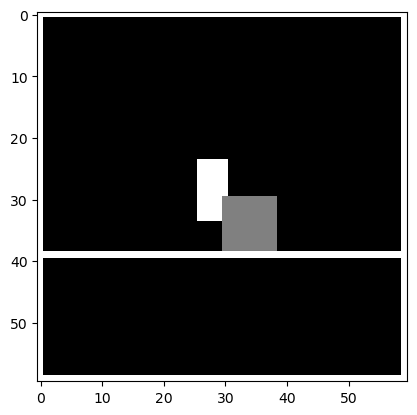

In [3]:
done = False
rewards = []
frames = []

state = env.reset()
while not done:
    action = np.random.randint(low=0, high=2)
    next_state, r, done, info = env.step(action)
    rewards.append(r)
    frames.append(np.flipud(state))
    state = next_state
    if done: 
        print("Done! Episode Reward: ", np.sum(rewards))
        plt.imshow(np.flipud(state), cmap='gray', vmin=0, vmax=1)
        break

# Augmentations

In [4]:
# convert the frames from [0., 1.] to [0, 255]
frames = np.array(np.array(frames) * 255, dtype=np.uint8)
# Convert the frame stack into the correct format (B, C, H, W)
if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)


print(frames.shape)
print(frames.dtype)

(26, 1, 60, 60)
uint8


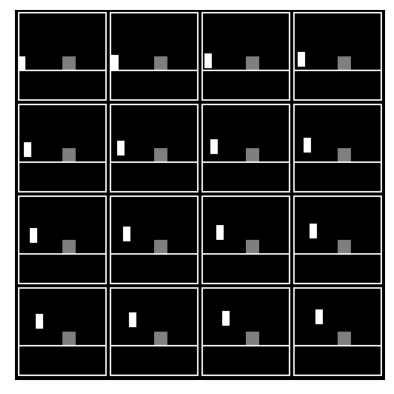

In [5]:
def show_imgs(x,max_display=16):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)

show_imgs(frames)

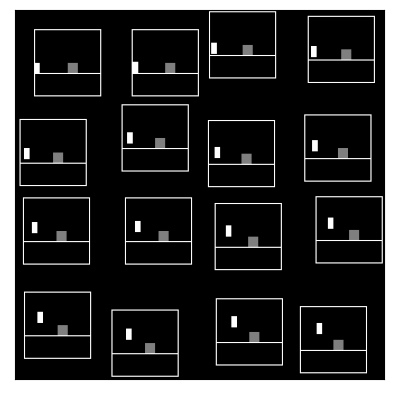

In [6]:
def random_translate(imgs, size, return_random_idxs=False, h1s=None, w1s=None):
    n, c, h, w = imgs.shape
    assert size >= h and size >= w
    outs = np.zeros((n, c, size, size), dtype=imgs.dtype)
    h1s = np.random.randint(0, size - h + 1, n) if h1s is None else h1s
    w1s = np.random.randint(0, size - w + 1, n) if w1s is None else w1s
    for out, img, h1, w1 in zip(outs, imgs, h1s, w1s):
        out[:, h1:h1 + h, w1:w1 + w] = img
    if return_random_idxs:  # So can do the same to another set of imgs.
        return outs, dict(h1s=h1s, w1s=w1s)
    return outs

rnd_trans = random_translate(frames,80)
show_imgs(rnd_trans)

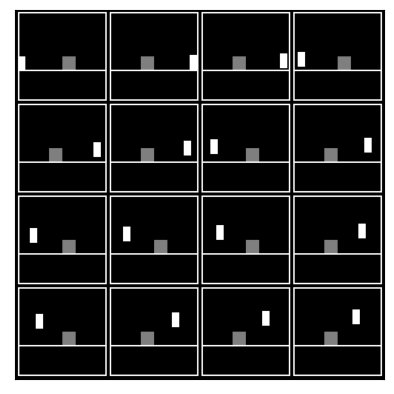

In [7]:
def random_flip(images,device,p=.5):
    # Taken from the RAD paper Laskin et al., 2020)
    # images: [B, C, H, W]
    
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    flipped_images = images.flip([3])
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    mask = rnd <= p
    mask = torch.from_numpy(mask)
    frames = images.shape[1] #// 3
    images = images.view(*flipped_images.shape)
    mask = mask[:, None] * torch.ones([1, frames]).type(mask.dtype)
    
    mask = mask.type(images.dtype).to(device)
    mask = mask[:, :, None, None]
    
    out = mask * flipped_images + (1 - mask) * images

    out = out.view([bs, -1, h, w])
    return out.type(torch.uint8)

flipped_x = random_flip(torch.from_numpy(frames),device)
show_imgs(flipped_x.numpy())

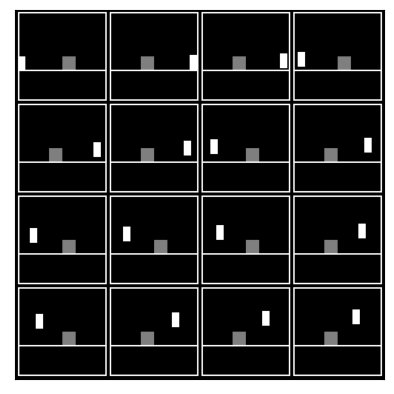

In [8]:
def random_crop(imgs, out):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    crop_max = h - out + 1
    w1 = np.random.randint(0, crop_max, n)
    h1 = np.random.randint(0, crop_max, n)
    cropped = np.empty((n, c, out, out), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        
        cropped[i] = img[:, h11:h11 + out, w11:w11 + out]
    return cropped

cropped_x = random_crop(frames,60)
show_imgs(flipped_x.numpy())

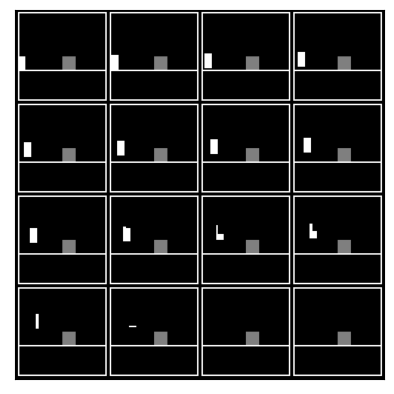

In [9]:
def random_cutout(imgs, min_cut,max_cut):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        #print(img[:, h11:h11 + h11, w11:w11 + w11].shape)
        cutouts[i] = cut_img
    return cutouts

cut_x = random_cutout(frames,10,15)
show_imgs(cut_x)

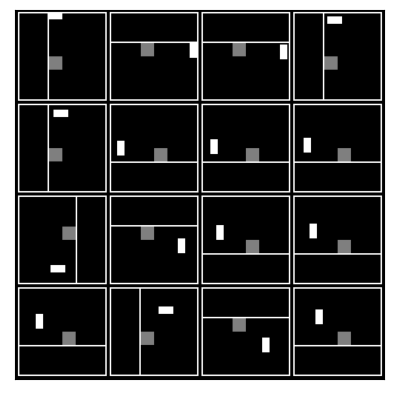

In [10]:
def random_rotation(images,device,p=.5):
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    rot90_images = images.rot90(1,[2,3])
    rot180_images = images.rot90(2,[2,3])
    rot270_images = images.rot90(3,[2,3])    
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    rnd_rot = np.random.randint(1, 4, size=(images.shape[0],))
    mask = rnd <= p
    mask = rnd_rot * mask
    mask = torch.from_numpy(mask).to(device)
    
    frames = images.shape[1]
    masks = [torch.zeros_like(mask) for _ in range(4)]
    for i,m in enumerate(masks):
        m[torch.where(mask==i)] = 1
        m = m[:, None] * torch.ones([1, frames]).type(mask.dtype).type(images.dtype).to(device)
        m = m[:,:,None,None]
        masks[i] = m
    
    
    out = masks[0] * images + masks[1] * rot90_images + masks[2] * rot180_images + masks[3] * rot270_images

    out = out.view([bs, -1, h, w])
    return out.type(torch.uint8)
rnd_rotation = random_rotation(torch.from_numpy(frames),device)
show_imgs(rnd_rotation.numpy())